In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from PIL import Image
# Load image crop 
crop_rgb = np.array(Image.open("foundpose_analysis/ycbv/templates/synthetic_images_templates/ycbv/train_pbr/obj_000002_original/000022.png").convert("RGB").resize((420,420))) # (124, 157, 3)
resized_crop_rgb = np.array(Image.open("foundpose_analysis/ycbv/templates/synthetic_images_templates/ycbv/train_pbr/obj_000002_original/000022.png").convert("RGB").resize((30,30))) # (124, 157, 3)
crop_mask = np.clip(np.sum(resized_crop_rgb, axis=-1), 0, 1).reshape(-1)

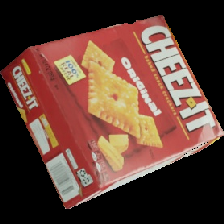

In [12]:
Image.open("foundpose_analysis/ycbv/templates/synthetic_images_templates/ycbv/train_pbr/obj_000002_original/000022.png")

In [6]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitl14.patch_size = 14
if torch.cuda.is_available():
    dinov2_vitl14 = torch.nn.DataParallel(dinov2_vitl14).to(device)  # Use DataParallel for multiple GPUs

Using cache found in /home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.vandam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [47]:
import torchvision.transforms as T
import torch.nn.functional as F
import torch

def patches_feature_extraction(template_patches, dinov2_vitl14, device):
    # crop_rgb: numpy array
    # temps = np.transpose(np.array(template_patches), (0,2,3,1))
    rgb_normalize = T.Compose(
        [
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )
    normalized_patches = torch.stack([rgb_normalize(patch) for patch in template_patches])
    layers_list = list(range(18))
    torch.cuda.empty_cache()
    with torch.no_grad(): 
        feature_patches= dinov2_vitl14.module.get_intermediate_layers(normalized_patches.to(device), n=layers_list, reshape=True, return_class_token=True)
    return feature_patches[-1][0] # Choose the last features as the feature after the 18th layer, 1 fo class token

In [48]:
crop_feature = patches_feature_extraction(np.expand_dims(crop_rgb, 0), dinov2_vitl14, device).permute(0,2,3,1).reshape(-1,1024)

In [39]:
crop_feature.shape

torch.Size([900, 1024])

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
pca_crop_patches_descriptors = pca.fit_transform(np.array(crop_feature.cpu()))
pca_crop_patches_descriptors.shape

(900, 256)

In [50]:
top3pca = pca_crop_patches_descriptors.reshape(30,30,-1)[:,:,:3]

In [52]:
def standard_normalize(image):
    return (image - image.mean()) / image.std()

normalized_image = standard_normalize(top3pca)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


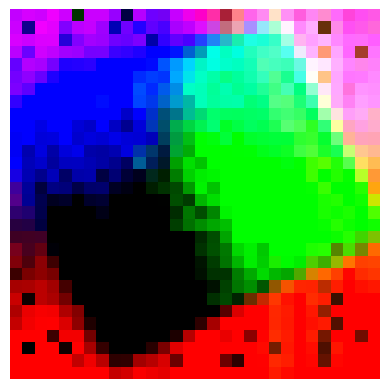

In [53]:
import matplotlib.pyplot as plt
# Display the image - 10* see lb the crop is normalized same way as the templates- ready to compare the similarity now
plt.imshow(normalized_image)
plt.axis('off')  # Optional: Turn off the axis
plt.show()

In [ ]:
"foundpose_analysis/ycbv/crop1.png"